In [84]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
from utils.visualization_utils import generic_plot, Curve, format_xtick, generic_sub_plot, Plot
from learning_models.torch_sir import SirEq

In [85]:
exp_dir = os.path.join("regioni", "heun_test_2")
results_path = os.path.join(os.getcwd(), exp_dir, "results")
if not os.path.exists(results_path):
    os.mkdir(results_path)

In [86]:
regions = ["Lombardia"]

In [87]:
def get_scores_path(region):
    return os.path.join(exp_dir, region, "scores.csv")

def get_df(region):
    path = get_scores_path(region)
    df = pd.read_csv(path, sep="\t")
    return df

def get_best_exp(df):
    return df[df.val_risk == df.val_risk.min()]

In [102]:
def compute_r0(df, t):
    df["r0_t" + str(t)] = df["final_beta_t" + str(t)] / df["final_gamma_t0"]

def get_list_from_column(df, raw_pos, column, max_size):
    col_val = df[column].iloc[raw_pos]
    x = literal_eval(col_val)
    return x +  [-1.0]*(max_size - len(x))

def add_integrator_column(df):
    df["integrator"] = df["name"].apply(lambda name: 'heun' if 'Heun' in name else 'euler' if 'euler' in name else 'rk4')

def add_id_column(df):
    df["id"] = df["integrator"] + "_" \
     + df["first_derivative_reg"].apply(str) + "_" \
     + df["t_inc"].apply(str) \
     #+ "_m" + df["m"].apply(str) + "_a" + df["a"].apply(str) + "_b" + df["b"].apply(str)

def get_res_parameters(scores_df, params=("beta", "gamma", "delta")):
    max_len = scores_df["train_size"].max()
    p_columns = ["final_" + p + "_t" + str(i) for p in params for i in range(max_len)]
    # all columns except beta/gamma/delta
    score_columns = list(set(scores_df.columns) - set(params))

    rows = []
    for column_idx in range(scores_df.shape[0]):
        # create rows for the params df
        values = []
        for param in params:
            # get the param as a list
            val = get_list_from_column(scores_df, column_idx, param, max_len)
            values.extend(val)
        # the row contains all scores + params (one column for each value of list)
        rows.append(list(scores_df.iloc[column_idx][score_columns]) + values)
    
    params_df = pd.DataFrame(rows, columns=score_columns + p_columns)

    for param in p_columns:
        #Set unavailable param as None
        params_df.loc[params_df[param] == -1, param] = None

    for t in range(max_len):
        # add r0_t to the df
        compute_r0(params_df, t)

    add_integrator_column(params_df)
    add_id_column(params_df)

    return params_df, p_columns

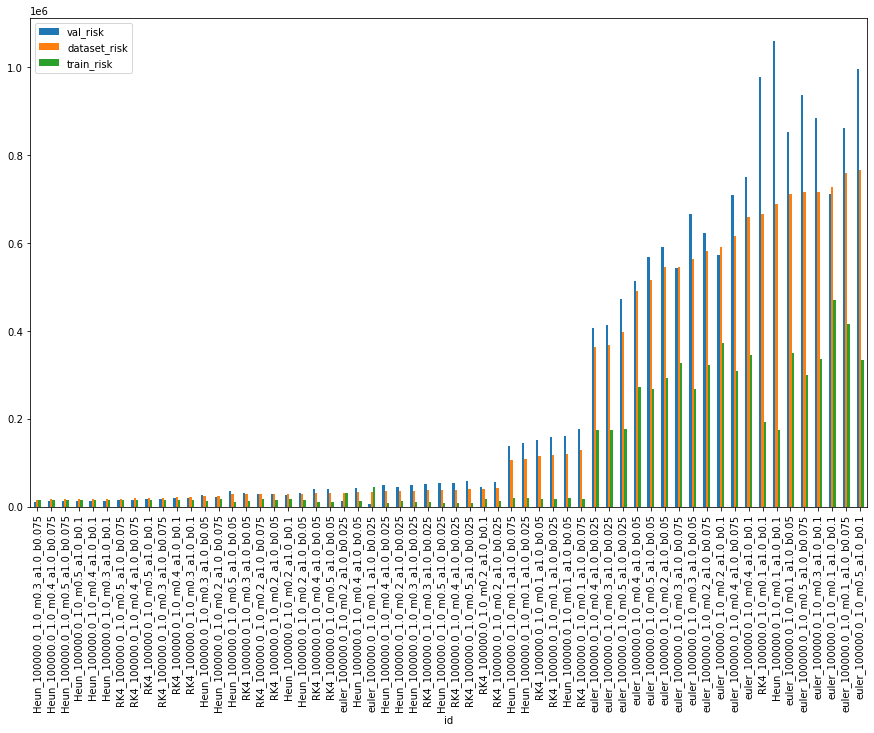

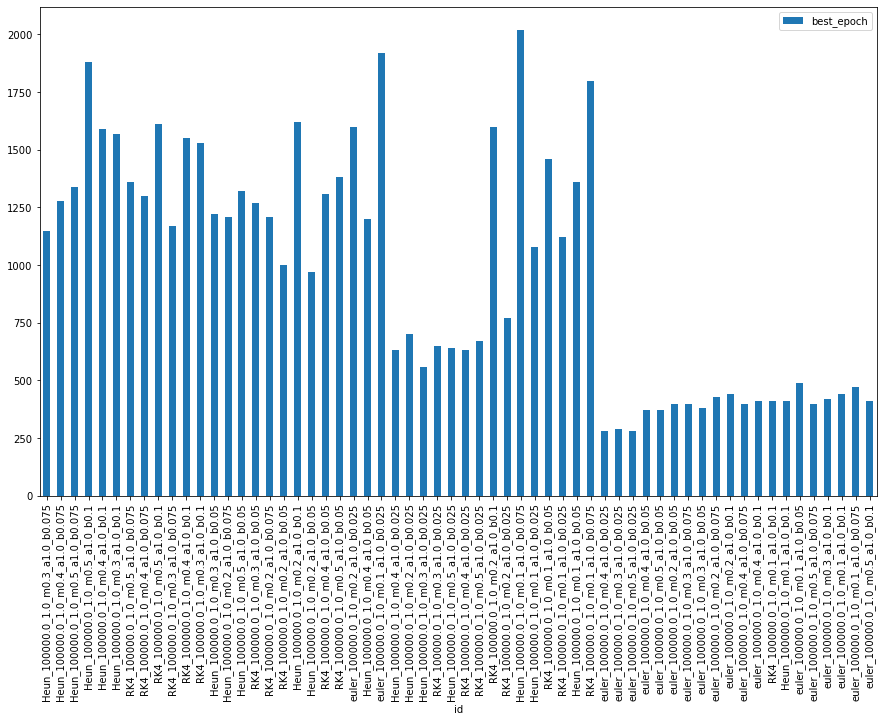

In [103]:
for region in regions:
    df = get_df(region)
    params_df, _ = get_res_parameters(df)
    params_df = params_df.sort_values(by=['dataset_risk'])
    #params_df.plot.bar(x='id', y='val_risk')
    #params_df.plot.bar(x='id', y='train_risk')
    #params_df.plot.bar(x='id', y='dataset_risk')    
    size = (15,9)
    params_df.plot.bar(x='id', y=['val_risk','dataset_risk', 'train_risk'], figsize=size)    

    params_df.plot.bar(x='id', y='best_epoch', figsize=size)